In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
event_data = pd.read_csv('event_data_train.csv')

In [41]:
submissions_data = pd.read_csv('submissions_data_train.csv')

In [4]:
event_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [21]:
event_data['date'] = pd.to_datetime(event_data.timestamp, unit='s')

In [42]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [23]:
event_data['day'] = event_data.date.dt.date

In [43]:
submissions_data['day'] = submissions_data.date.dt.date

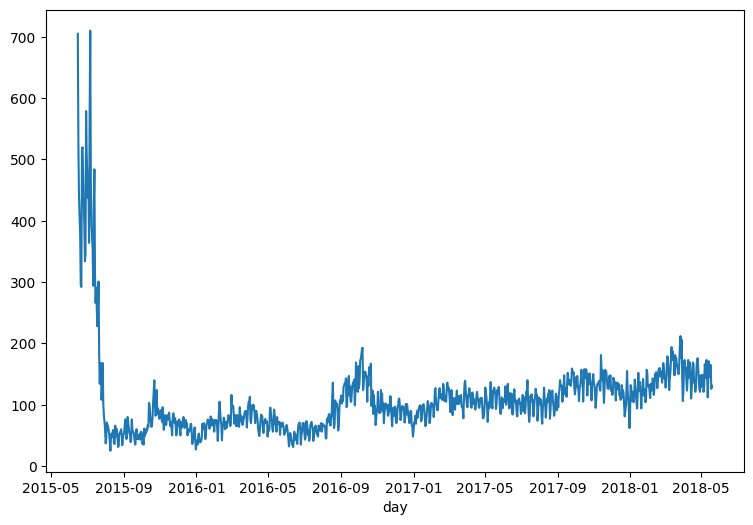

In [36]:
event_data.groupby('day').user_id.nunique().plot(figsize=(9,6))
plt.show()

In [88]:
users_event_data = event_data.pivot_table(index='user_id',
                       columns='action',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index()

In [44]:
users_scores = submissions_data.pivot_table(index='user_id',
                       columns='submission_status',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index()

In [47]:
gap_data = event_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [49]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [52]:
gap_data = gap_data / (24 * 60 * 60)

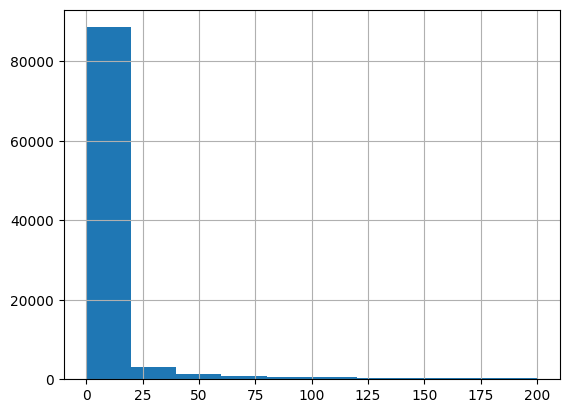

In [54]:
gap_data[gap_data < 200].hist()
plt.show()

In [55]:
gap_data.quantile(0.90)

18.325995370370403

In [73]:
now = event_data.timestamp.max()
drop_out = 2592000

In [81]:
users_data = event_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [82]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out

In [91]:
users_data = users_data.merge(users_scores, on='user_id', how='outer').fillna(0).head()

In [89]:
users_data = users_data.merge(users_event_data, how='outer')

In [92]:
users_days = event_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [93]:
users_data = users_data.merge(users_days, how='outer')

In [94]:
users_data['passed_course'] = users_data.passed > 170